## Experiments - GMMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
events = pd.read_csv('data/events_filtered.csv')
events_beyms = pd.read_csv('data/beyms_events.csv')
events_ms = pd.read_csv('data/ms_events.csv')
country_idf = pd.read_csv('data/country_idf.csv')
tracks_idf = pd.read_csv('data/tracks_idf.csv')
tracks_sample = pd.read_csv('data/all_tracks_sample.csv') 
tracks = pd.read_csv('data/LFM-1b_tracks.txt', sep="\t", header=None, names=['track_id','track','artist_id'])
artists = pd.read_csv('data/LFM-1b_artists.txt', sep="\t", header=None, names=['artist_id','artist'])
acoustic_features = pd.read_csv('data/acoustic_features_lfm_id.tsv', sep='\t')

In [3]:
len(events_ms['user_id'].drop_duplicates())

2074

In [4]:
len(events_beyms['user_id'].drop_duplicates())

2073

### Preprocessing

In [5]:
# Features
featuresdf = pd.merge(acoustic_features[acoustic_features['track_id'].isin(tracks_sample['track_id'])], tracks_idf, on=['track_id'])
features_df = featuresdf[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness", "idf_scores"]]
features_df = pd.DataFrame(index=features_df.index, columns=features_df.columns, data=MinMaxScaler().fit_transform(features_df))
features_df['track_id'] = featuresdf['track_id']
features_df.head()

,danceability,energy,speechiness,acousticness,instrumentalness,tempo,valence,liveness,idf_scores,track_id
0,0.534604,0.399990,0.003905,0.905622,0.91000,0.526916,0.563996,0.105751,0.078057,299887
1,0.546640,0.719995,0.023749,0.000801,0.00000,0.704192,0.801998,0.204329,0.171041,3869192
2,0.628887,0.591993,0.003694,0.182731,0.00808,0.560200,0.387994,0.076278,0.233921,3398243
3,0.514544,0.511992,0.004644,0.002219,0.09760,0.439788,0.373994,0.073361,0.078057,1214807
4,0.295888,0.497991,0.008972,0.798193,0.94400,0.356192,0.039890,0.101727,0.218190,29635532


In [6]:
events = events[events['track_id'].isin(tracks_sample['track_id'])]
listening_counts = events[['user_id','track_id','artist_country_id']].groupby(['user_id','track_id']).value_counts().reset_index() # 5,329,179
listening_counts = listening_counts.rename(columns={0:'count'})
listening_counts = pd.merge(pd.merge(listening_counts, tracks, on=['track_id'], how='left'), artists, on=['artist_id'], how='left')
listening_counts = pd.merge(listening_counts, country_idf, left_on='artist_country_id', right_on='country_id', how='left')

In [7]:
# Removing missing tracks names
features_df = features_df[~features_df['track_id'].isin(listening_counts[listening_counts['track'].isna()]['track_id'])]
listening_counts = listening_counts.dropna() 
listening_counts['song'] = listening_counts['track'].map(str) + " - " + listening_counts['artist'] + " (" + listening_counts['Code'] + ")"
tracks_counts = listening_counts.groupby(['track_id','song', 'Code']).agg({'count':'count'}).sort_values(by='count',ascending=False).reset_index()

In [8]:
# Metada for results
tracks_meta = pd.merge(listening_counts[['track_id', 'song','artist_country_id']].drop_duplicates(), country_idf, left_on='artist_country_id', right_on='country_id', how='left')
tracks_meta = pd.merge(tracks_meta, tracks_sample[['track_id','group']], on='track_id', how='left')

In [9]:
features_df = features_df[features_df['track_id'].isin(tracks_meta['track_id'])]

In [10]:
# Train data
train = features_df[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness", "idf_scores"]]
train_non = features_df[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness"]]
train_non = np.nan_to_num(train_non)
train = np.nan_to_num(train)

In [11]:
items = listening_counts['track_id'].unique()

### Precision and recall

In [12]:
def precision(targets, predictions, max_pred):
    """Calculate precision and recall"""
    
    predictions = predictions[:max_pred]

    test_set = set(targets)
    precision = float(len(set(predictions).intersection(test_set))) / max_pred
    recall = float(len(set(predictions).intersection(test_set))) / float(len(test_set))

    return precision, recall

### Content-based recommendation

In [13]:
def get_user_mean_features_cb(user_id, idf):
    """Get user features vector."""

    if idf == True:
        features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness", "idf_scores"]
    else:
        features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness"]

    list_features = features_df[features_df['track_id'].isin(events['track_id'][(events['user_id']==user_id)].drop_duplicates())]
    train_x, test_x = train_test_split(list_features, test_size=0.20, random_state=21038875)
    train_x_features = train_x[features]
    user_mean_features = np.array(train_x_features.mean(axis=0))
    user_mean_features = np.nan_to_num(user_mean_features)
    
    return user_mean_features, train_x['track_id'], test_x['track_id']
    
def cb_recommendation(user_id, train_data, idf=True, top_tracks=10):
    """Get recommendations."""
    
    user_mean_features, train_x, test_x = get_user_mean_features_cb(user_id, idf)
    
    cosine_features = cosine_similarity(user_mean_features.reshape(1, -1),train_data)
    
    score = list(enumerate(cosine_features[0]))
    
    similarity_score = sorted(score, key = lambda x:x[1], reverse = True)
    
    similarity_score = similarity_score[:top_tracks]
    top_songs_index = [i[0] for i in similarity_score]
    
    top_songs = pd.merge(features_df['track_id'].iloc[top_songs_index],tracks_meta[['track_id','song','Code','group']], on='track_id', how='left')
    top_songs['user_id'] = user_id
    top_songs['precision_val'], top_songs['recall_val'] = precision(test_x, top_songs['track_id'], top_tracks)
    
    train_x = train_x.to_frame()
    test_x = test_x.to_frame()
    train_x['user_id'] = user_id
    test_x['user_id'] = user_id
    
    return top_songs, train_x, test_x

### PCA recommendation

In [14]:
pca = PCA()
X_train_non_pca = pca.fit_transform(train_non)
print("sklearn var:\n", pca.explained_variance_ratio_)

sklearn var:
 [0.37662626 0.26782698 0.14591953 0.0747538  0.04863181 0.03746187
 0.02648363 0.02229612]


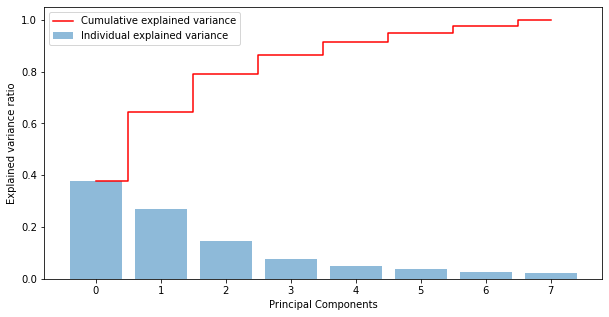

In [15]:
plt.figure(figsize=(10,5))
plt.bar(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,
        alpha=0.5,
        align='center',
        label='Individual explained variance')
plt.step(range(0,len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         color='red',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

In [16]:
pca_non = PCA(n_components=3)
pComponents_non = pca_non.fit_transform(train_non)
pcadf_non = pd.DataFrame(data = pComponents_non, columns = ['pca_01', 'pca_02', 'pca_03'])
pca_non_df = pd.concat([pcadf_non,features_df['track_id']], axis=1)


In [17]:
pca = PCA()
X_train_pca = pca.fit_transform(train)
print("sklearn var:\n", pca.explained_variance_ratio_)

sklearn var:
 [0.36477623 0.25943582 0.14133051 0.07245464 0.04710147 0.0365825
 0.03133725 0.02562419 0.02135741]


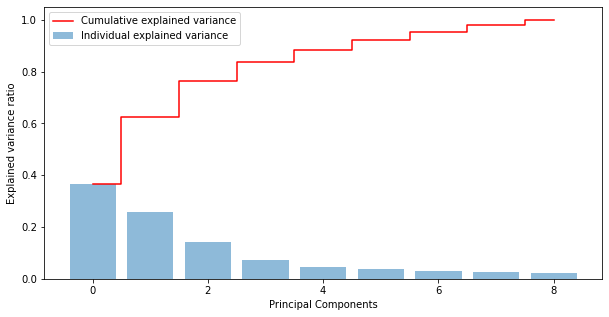

In [18]:
plt.figure(figsize=(10,5))
plt.bar(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,
        alpha=0.5,
        align='center',
        label='Individual explained variance')
plt.step(range(0,len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         color='red',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

In [19]:
pca = PCA(n_components=3)
pComponents = pca.fit_transform(train)
pcadf = pd.DataFrame(data = pComponents, columns = ['pca_01', 'pca_02', 'pca_03'])
pca_df = pd.concat([pcadf,features_df['track_id']], axis=1)

In [20]:
def get_user_mean_features_pca(user_id, idf):
    """Get user features vector."""
    
    if idf == True:
        features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness", "idf_scores"]
        trans = pca
    else:
        features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness"]
        trans = pca_non
    
    list_features = features_df[features_df['track_id'].isin(events['track_id'][(events['user_id']==user_id)].drop_duplicates())]
    train_x, test_x = train_test_split(list_features, test_size=0.20, random_state=21038875)   
    train_x_features = train_x[features]
    user_mean_features = np.array(train_x_features.mean(axis=0))
    user_mean_features = np.nan_to_num(user_mean_features)
    user_mean_features = trans.transform(user_mean_features.reshape(1, -1))
    
    return user_mean_features, train_x['track_id'], test_x['track_id']


def cb_recommendation_pca(user_id, train_data, idf=True, top_tracks=10):
    """Get recommendations."""
    
    user_mean_features, train_x, test_x = get_user_mean_features_pca(user_id, idf)
    
    cosine_features = cosine_similarity(user_mean_features.reshape(1, -1),train_data)
    
    score = list(enumerate(cosine_features[0]))
    
    similarity_score = sorted(score, key = lambda x:x[1], reverse = True)
    
    similarity_score = similarity_score[:top_tracks]
    top_songs_index = [i[0] for i in similarity_score]
    
    top_songs = pd.merge(features_df['track_id'].iloc[top_songs_index],tracks_meta[['track_id','song','Code','group']], on='track_id', how='left')
    top_songs['user_id'] = user_id
    
    top_songs['precision_val'], top_songs['recall_val'] = precision(test_x, top_songs['track_id'], top_tracks)

    train_x = train_x.to_frame()
    test_x = test_x.to_frame()
    train_x['user_id'] = user_id
    test_x['user_id'] = user_id
    
    return top_songs, train_x, test_x

### Random recommendation

In [21]:
def get_user_mean_features_rand(user_id):
    """Get user features vector."""

    list_features = features_df[features_df['track_id'].isin(events['track_id'][(events['user_id']==user_id)].drop_duplicates())]
    train_x, test_x = train_test_split(list_features, test_size=0.20, random_state=21038875)

    return train_x['track_id'], test_x['track_id']


def random_recommendation(user_id, train_data, idf=True, top_tracks=10):
    """Get recommendations."""
    
    np.random.seed(21038875)
    
    train_x, test_x = get_user_mean_features_rand(user_id)
    
    
    top_songs=tracks_counts[~tracks_counts['track_id'].isin(train_x)].sample(top_tracks)
    
    top_songs = pd.merge(top_songs,tracks_meta[['track_id','group']], on='track_id', how='left')
    top_songs['user_id'] = user_id
    
    top_songs['precision_val'], top_songs['recall_val'] = precision(test_x, top_songs['track_id'], top_tracks)
    
    train_x = train_x.to_frame()
    test_x = test_x.to_frame()
    train_x['user_id'] = user_id
    test_x['user_id'] = user_id
    
    return top_songs, train_x, test_x

### Popular recommendations

In [22]:
def get_user_mean_features_pop(user_id):
    """Get user features vector."""

    list_features = features_df[features_df['track_id'].isin(events['track_id'][(events['user_id']==user_id)].drop_duplicates())]
    train_x, test_x = train_test_split(list_features, test_size=0.2, random_state=21038875)

    return train_x['track_id'], test_x['track_id']


def popular_recommendation(user_id, train_data, idf=True, top_tracks=10):
    """Get recommendations."""
    
    train_x, test_x = get_user_mean_features_pop(user_id)
    top_songs=tracks_counts[~tracks_counts['track_id'].isin(train_x)][:top_tracks]
    
    top_songs = pd.merge(top_songs,tracks_meta[['track_id','group']], on='track_id', how='left')
    top_songs['user_id'] = user_id
    
    top_songs['precision_val'], top_songs['recall_val'] = precision(test_x, top_songs['track_id'], top_tracks)
    
    train_x = train_x.to_frame()
    test_x = test_x.to_frame()
    train_x['user_id'] = user_id
    test_x['user_id'] = user_id
    
    return top_songs, train_x, test_x

### Results

In [23]:
def run_test(type_test, MRI_recommendation, users, train_data, idf, top_n_tracks=10):
    """Run recommendations for users and data"""
    
    start = time.time()
    
    recommendations = pd.DataFrame()
    train = pd.DataFrame()
    test = pd.DataFrame()
    total_users = 0

    for i in users['user_id'].drop_duplicates():
        total_users += 1
        MRI, train_x, test_x = MRI_recommendation(i, train_data, idf, top_n_tracks)
        recommendations = pd.concat([recommendations,MRI])
        train = pd.concat([train_x, train])
        test = pd.concat([test_x, test])
    

    recommendations_bygroup = recommendations.groupby(['user_id','group']).size().reset_index()
    recommendations_bygroup = recommendations_bygroup.rename(columns={0:'count'})
    recommendations_stats = round((recommendations_bygroup.groupby(['user_id','group']).sum()/top_n_tracks*100).groupby('group').sum()/total_users,2)
    recommendations_p_r = recommendations[['user_id','precision_val','recall_val']].drop_duplicates()
    precision = recommendations_p_r['precision_val'].sum()/len(recommendations_p_r)
    recall = recommendations_p_r['recall_val'].sum()/len(recommendations_p_r)
    N = top_n_tracks

    try:
        pct_g1 = recommendations_stats.iloc[0]['count']
    except (IndexError, ValueError):
        pct_g1 = 'null'

    try:
        pct_g2 = recommendations_stats.iloc[1]['count']
    except (IndexError, ValueError):
        pct_g2 = 'null'

    try:
        pct_g3 = recommendations_stats.iloc[2]['count']
    except (IndexError, ValueError):
        pct_g3 = 'null'

    end = time.time()
    
    recommendations['type_test'] = type_test
    train['type_test'] = type_test
    test['type_test'] = type_test
    
    print(end-start)
    
    return pct_g1, pct_g2, pct_g3, precision, recall, N, total_users, type_test, recommendations, train, test

In [24]:
reco = pd.DataFrame(columns=['track_id','song','Code','group','user_id','precision_val','recall_val','type_test'])
train_set = pd.DataFrame(columns=['track_id','user_id','type_test'])
test_set = pd.DataFrame(columns=['track_id','user_id','type_test'])

In [25]:
results = []

In [26]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_idf', cb_recommendation, events_beyms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

2125.816519021988


In [27]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_noidf', cb_recommendation, events_beyms, train_non, False, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1988.1497509479523


In [28]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_idf', cb_recommendation, events_ms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1873.1816310882568


In [29]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_noidf', cb_recommendation, events_ms, train_non, False, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1848.6851148605347


In [30]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_idf_pca', cb_recommendation_pca, events_beyms, pcadf, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1710.3407971858978


In [31]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_noidf_pca', cb_recommendation_pca, events_beyms, pcadf_non, False, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1733.5463650226593


In [32]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_idf_pca', cb_recommendation_pca, events_ms, pcadf, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1748.9714381694794


In [33]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_noidf_pca', cb_recommendation_pca, events_ms, pcadf_non, False, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

1761.5718960762024


In [34]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_rnd', random_recommendation, events_beyms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

332.33831310272217


In [35]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_rnd', random_recommendation, events_ms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

337.5101261138916


In [36]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('beyms_pop', popular_recommendation, events_beyms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

307.9380009174347


In [37]:
r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11 = run_test('ms_pop', popular_recommendation, events_ms, train, True, 10)
results.append([r1,r2,r3,r4,r5,r6,r7,r8])
reco = pd.concat([reco,r9])
train_set = pd.concat([train_set,r10])
test_set = pd.concat([test_set,r11])

305.6784300804138


In [38]:
df = pd.DataFrame(data = results, columns=['pct_g1', 'pct_g2', 'pct_g3', 'precision', 'recall', 'N', 'total_users', 'type_test'])

### Table of results

In [39]:
df

,pct_g1,pct_g2,pct_g3,precision,recall,N,total_users,type_test
0,16.17,65.81,18.02,0.001013,0.000048,10,2073,beyms_idf
1,36.67,32.09,31.24,0.000579,0.000021,10,2073,beyms_noidf
2,16.40,70.48,13.11,0.000579,0.000024,10,2074,ms_idf
3,36.87,31.89,31.24,0.000530,0.000022,10,2074,ms_noidf
4,35.31,31.90,32.79,0.000868,0.000037,10,2073,beyms_idf_pca
5,35.62,31.66,32.71,0.000965,0.000040,10,2073,beyms_noidf_pca
6,35.95,31.64,32.41,0.000675,0.000020,10,2074,ms_idf_pca
7,35.49,31.98,32.54,0.000723,0.000026,10,2074,ms_noidf_pca
8,35.38,31.50,33.13,0.000048,0.000002,10,2073,beyms_rnd
9,35.43,31.74,32.84,0.000289,0.000011,10,2074,ms_rnd


In [40]:
# Export results

#features_df.to_csv('LFM-BeyMS_MRS_features_reco.csv')
#reco.to_csv('LFM-BeyMS_MRS_experiments_reco.csv')
#train_set.to_csv('LFM-BeyMS_MRS_experiments_train_set.csv')
#test_set.to_csv('LFM-BeyMS_MRS_experiments_test_set.csv')
#df.to_csv('LFM-BeyMS_MRS_experiments_df.csv')